# Project Part B: Representation

![](banner_project.jpg)

In [1]:
analyst = "Priscila Carcamo Amorim" # Replace this with your name

In [2]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
options(repr.matrix.max.rows=674)
options(repr.matrix.max.cols=200)
update_geom_defaults("point", list(size=1))                                

.................................................... start of document ....................................................

## Directions

### Objective

Transform the representation of a dataset about public company fundamentals.  Later, use the transformed dataset along with additional analysis to recommend a portfolio of 12 company investments that maximizes 12-month return of an overall \$1,000,000 investment.

### Approach

Retrieve a public company fundamentals dataset comprising thousands of US companies from quarters 1, 2, 3, and 4 of year 2017 + company stock price data for those companies from quarter 4 of year 2018.

Transform the dataset representation to capture all information about any single company in a single observation.

Additionally transform the dataset representation using variable filtration, imputation, principal component analysis, and other methods.

### Data Source

The data includes these files:

* Data Dictionary.csv
* Company Fundamentals 2017.csv
* Company Fundamentals 2018.csv

The dataset and accompanying data dictionary was sourced from ...

* Wharton Research Data Services > Compustat - Capital IQ from Standard & Poor's > North America - Daily > Fundamentals Quarterly (https://wrds-www.wharton.upenn.edu/)

  * Date Variable: Data Date
  * Date Range: 2017-01 to 2017-12 -or- 2018-01 to 2018-12
  * Company Codes: Search the entire database
    * Consolidtaion Level: C, Output
    * Industry Format: INDL, FS, Output
    * Data Format: STD, Output
    * Population Source: D, Output
    * Quarter Type: Fiscal View, Output
    * Currency: USD, Output (not CAD)
    * Company Status: Active, Output (not Inactive)
  * Variable Types: Data Items, Select All (674)
  * Query output:
    * Output format: comma-delimited text
    * Compression type: None
    * Data format: MMDDYY10

The dataset is restricted to select US active, publicly held companies that reported quarterly measures including stock prices for 1st, 2nd, 3rd, and 4th quarters in years 2017 and 2018.  All non-missing stock prices exceed $3 per share.  File formats are all comma-separated values (CSV).

The data dictionary is from Variable Descriptions tab, copied to Excel, saved in csv format.

_**For this project, do not source any data from year 2019.**_

## Data

_<< Discuss this data retrieval. >>_  
  
**ANSWER:**  
  
We first further expand the original data for the 2017 fiscal year by quarter to get the corresponding data per quarter. This leads to us merging all of the expanded data, thus resulting in many more columns than the original 2017 data set. However, this makes it easier for data retrieval. For instance, if we'd like to get the stock price for quarter 3 of 2017 for a particular company, we can simply select the column rather than filtering the rows by values. We do something similar to the 2018 fiscal year data set, but we only keep the quarter 4 data for 2018. To consolidate the current year and next year data, we merge the data sets together. The threshold is set to 0.30 to later determine whether a particular company experienced "big" growth, which is growth that exceeds 30%.  
  
After consolidating the data sets, we determine which variables can be used for prediction and which for outcome. We see that predictor variables include: each company's unique ID, each company's name, dates, and more. The outcome variables include: the stock price in 2018 quarter 4, growth, and big growth. 

In [3]:
threshold = 0.30

In [4]:
# Current Year

datax = read.csv("Company Fundamentals 2017.csv", header=TRUE)

datax$quarter = quarter(mdy(datax[,2]))

data.current.q1 = datax[(datax$quarter==1) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]
data.current.q2 = datax[(datax$quarter==2) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]
data.current.q3 = datax[(datax$quarter==3) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]
data.current.q4 = datax[(datax$quarter==4) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]

data.current.q1 = data.current.q1[!duplicated(data.current.q1$gvkey),]
data.current.q2 = data.current.q2[!duplicated(data.current.q2$gvkey),]
data.current.q3 = data.current.q3[!duplicated(data.current.q3$gvkey),]
data.current.q4 = data.current.q4[!duplicated(data.current.q4$gvkey),]

colnames(data.current.q1)[-c(1, 10, 12)] = paste0(colnames(data.current.q1)[-c(1, 10, 12)], ".q1")
colnames(data.current.q2)[-c(1, 10, 12)] = paste0(colnames(data.current.q2)[-c(1, 10, 12)], ".q2")
colnames(data.current.q3)[-c(1, 10, 12)] = paste0(colnames(data.current.q3)[-c(1, 10, 12)], ".q3")
colnames(data.current.q4)[-c(1, 10, 12)] = paste0(colnames(data.current.q4)[-c(1, 10, 12)], ".q4")

m12 = merge(data.current.q1, data.current.q2, by=c("gvkey", "tic", "conm"), all=TRUE)
m34 = merge(data.current.q3, data.current.q4, by=c("gvkey", "tic", "conm"), all=TRUE)
data.current = merge(m12, m34, by=c("gvkey", "tic", "conm"), all=TRUE, sort=TRUE)

data.current = data.current[!is.na(data.current$prccq.q4),]


# Next Year

datax = read.csv("Company Fundamentals 2018.csv", header=TRUE)

datax$quarter = quarter(mdy(datax[,2]))
data.future.q4 = datax[(datax$quarter==4) & !is.na(datax$prccq), c("gvkey", "prccq")]
data.future.q4 = data.future.q4[!duplicated(data.future.q4$gvkey),]


# Consolidated Current Year / Next Year

data = merge(data.current, data.future.q4, by="gvkey", all=FALSE)

data$growth = (data$prccq - data$prccq.q4) / data$prccq.q4
data$big_growth = factor(data$growth >= threshold, levels=c(FALSE, TRUE), labels=c("NO", "YES"))


# Present a few rows ...

data[1:3,]

gvkey,tic,conm,datadate.q1,fyearq.q1,fqtr.q1,fyr.q1,indfmt.q1,consol.q1,popsrc.q1,datafmt.q1,cusip.q1,acctchgq.q1,acctstdq.q1,adrrq.q1,ajexq.q1,ajpq.q1,bsprq.q1,compstq.q1,curcdq.q1,curncdq.q1,currtrq.q1,curuscnq.q1,datacqtr.q1,datafqtr.q1,finalq.q1,ogmq.q1,rp.q1,scfq.q1,srcq.q1,staltq.q1,updq.q1,apdedateq.q1,fdateq.q1,pdateq.q1,rdq.q1,acchgq.q1,acomincq.q1,acoq.q1,actq.q1,altoq.q1,ancq.q1,anoq.q1,aociderglq.q1,aociotherq.q1,aocipenq.q1,aocisecglq.q1,aol2q.q1,aoq.q1,apq.q1,aqaq.q1,aqdq.q1,aqepsq.q1,aqpl1q.q1,aqpq.q1,arcedq.q1,arceepsq.q1,arceq.q1,atq.q1,aul3q.q1,billexceq.q1,capr1q.q1,capr2q.q1,capr3q.q1,capsftq.q1,capsq.q1,ceiexbillq.q1,ceqq.q1,cheq.q1,chq.q1,cibegniq.q1,cicurrq.q1,ciderglq.q1,cimiiq.q1,ciotherq.q1,cipenq.q1,ciq.q1,cisecglq.q1,citotalq.q1,cogsq.q1,csh12q.q1,cshfd12.q1,cshfdq.q1,cshiq.q1,cshopq.q1,cshoq.q1,cshprq.q1,cstkcvq.q1,cstkeq.q1,cstkq.q1,dcomq.q1,dd1q.q1,deracq.q1,deraltq.q1,derhedglq.q1,derlcq.q1,derlltq.q1,diladq.q1,dilavq.q1,dlcq.q1,⋯,stkcpay.q4,tdcy.q4,tfvcey.q4,tiey.q4,tiiy.q4,tsafcy.q4,txachy.q4,txbcofy.q4,txbcoy.q4,txdcy.q4,txdiy.q4,txpdy.q4,txty.q4,txwy.q4,uaolochy.q4,udfccy.q4,udvpy.q4,ufretsdy.q4,ugiy.q4,uniamiy.q4,unopincy.q4,unwccy.q4,uoisy.q4,updvpy.q4,uptacy.q4,uspiy.q4,ustdncy.q4,usubdvpy.q4,utfdocy.q4,utfoscy.q4,utmey.q4,uwkcapcy.q4,wcapchy.q4,wcapcy.q4,wday.q4,wddy.q4,wdepsy.q4,wdpy.q4,xidocy.q4,xidoy.q4,xinty.q4,xiy.q4,xopry.q4,xoptdqpy.q4,xoptdy.q4,xoptepsqpy.q4,xoptepsy.q4,xoptqpy.q4,xopty.q4,xrdy.q4,xsgay.q4,exchg.q4,cik.q4,costat.q4,fic.q4,cshtrq.q4,dvpspq.q4,dvpsxq.q4,mkvaltq.q4,prccq.q4,prchq.q4,prclq.q4,adjex.q4,add1.q4,add2.q4,add3.q4,add4.q4,addzip.q4,busdesc.q4,city.q4,conml.q4,county.q4,dlrsn.q4,ein.q4,fax.q4,fyrc.q4,ggroup.q4,gind.q4,gsector.q4,gsubind.q4,idbflag.q4,incorp.q4,loc.q4,naics.q4,phone.q4,prican.q4,prirow.q4,priusa.q4,sic.q4,spcindcd.q4,spcseccd.q4,spcsrc.q4,state.q4,stko.q4,weburl.q4,dldte.q4,ipodate.q4,prccq,growth,big_growth
1004,AIR,AAR CORP,02/28/2017,2016,3,5,INDL,C,D,STD,000361105,,DS,NA,1,1,,AZ,USD,USD,1,NA,2017Q1,2016Q3,Y,,Q,7,5,,3,02/28/2017,03/23/2017,03/21/2017,03/21/2017,0,-46.400,28.000,893.100,90.500,609.000,NA,0.000,0,-42.500,0,NA,248.500,194.600,NA,NA,NA,NA,NA,NA,NA,NA,1502.100,NA,NA,NA,NA,NA,NA,457.300,NA,885.700,10.100,10.100,13.700,-0.200,0.000,0,0,0.3,13.800,0,13.800,340.70,33.9250,34.2750,34.200,45.170,0.052,34.324,33.700,1.00,-0.1,45.200,0,2.000,NA,NA,NA,NA,NA,0,14.300,2.000,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,-22.100,NA,14.700,11.200,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.2,-36.2,3.600,0,758.700,NA,NA,NA,NA,NA,NA,NA,93.300,11,1750,A,USA,13354306,0.075,0.075,1444.0318,41.58,41.940,34.25,1,"One AAR Place, 1100 North Wood Dale Road",,,NA,60191,"AAR Corp. provides products and services to commercial aviation, government, and defense markets worldwide. The company operates in two segments, Aviation Services and Expeditionary Services.",Wood Dale,AAR Corp,,NA,36-2334820,630-227-2039,5,2010,201010,20,20101010,D,DE,USA,423860,630-227-2000,,,1,5080,110,925,B,IL,0,www.aarcorp.com,NA,01/01/1988,43.69,0.05074555,NO
1045,AAL,AMERICAN AIRLINES GROUP INC,03/31/2017,2017,1,12,INDL,C,D,STD,02376R102,,DS,NA,1,1,,AC,USD,USD,1,NA,2017Q1,2017Q1,Y,,Q,7,5,,3,03/31/2017,04/27/2017,,04/27/2017,0,-5097.000,856.000,10626.000,3383.000,42001.000,0,0.000,-669,-4428.000,0,6145,9710.000,1882.000,NA,NA,NA,700,NA,NA,NA,NA,52627.000,0,NA,NA,NA,NA,NA,6726.000,NA,3457.000,7219.000,374.000,340.000,0.000,0.000,0,0,-14.0,326.000,0,326.000,6774.00,526.7220,530.1763,507.797,495.750,11.677,495.750,503.902,0.01,0.0,5.000,0,1714.000,NA,NA,NA,NA,NA,0,340.000,1714.000,⋯,NA,NA,NA,NA,NA,NA,0.000,0,0,1141.000,2089.000,20.000,2113.000,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.0,0.0,1102.000,0,35640.000,NA,NA,NA,NA,NA,NA,NA,7240.000,14,6201,A,USA,270496454,0.100,0.100,24740.6812,52.03,53.740,45.27,1,1 Skyview Drive,,,NA,76155,"American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. It provide

In [5]:
# Identify which variables can later be used as
# outcome variables and which can be used as predictor variables.

outvars = c("prccq", "growth", "big_growth")
prevars = setdiff(colnames(data), outvars)
layout(fmt(outvars), fmt(prevars[1:10], "prevars (first few)"))

outvars
prccq
growth
big_growth
prevars (first few)
gvkey
tic
conm
datadate.q1
fyearq.q1
fqtr.q1


## Transform Representation of Data

_<< Discuss this new representation of data. >>_  
  
**ANSWER:**  
  
We first filter the data to only have columns that are predictor variables, which we determined above. We also only want to include predictor variables that only have a maximum of 20% missing values so that we don't impute too much data in places with NULL values. This is because we do not want to misrepresent the data or impute it incorrectly to the point that the data will be heavily changed. We impute the data based on the type/class of the variable; if the variable is numeric, we impute it with the mean of that variable. However, if the class is non-numeric, we impute the missing data with the mode. This should not change the number of variables or observations from our variable filtration step; it simply adds in data that is predicted that would have been the value.   
  
For principal component analysis, or PCA, we further filter the data to only work with numeric or integer variables that don't have zero-variance. The purpose of performing PCA is to determine which variables have the most variation; we can then use those variables for modeling and analysis since it should be able to best describe and distinguish data points the best. From the bar chart visualization, we see that PC1 and PC2 have the most variation from all other variables. This means that in our future analyses, we should use the variables that correspond to PC1 and PC2 because they can best represent the data. However, with the scatter plot visualization, we don't see a trend with PC1 and PC2 in terms of big growth. In other words, having a particular PC1 and PC2 value does not directly correspond to big growth or no/small growth. Thus, we cannot definitely recommend any particular portfolio based on only PC1 and PC2. In other words, PC1 and PC2 are not solid predictor variables for predicting the outcome variables.

### Variable Filtration

In [6]:
# Filter the data to include only predictor variables with at least 80% non-missing values. 
# Keep the variable names from the resulting dataset for later use.
# How many observations and variables in the resulting dataset?
#
# You can use the var_info.na_count() function.

num.rows = nrow(data)
max.na_values = num.rows * 0.2
boolean.array = var_info.na_count(data) < max.na_values
boolean.array['prccq'] = FALSE
boolean.array['growth'] = FALSE
boolean.array['big_growth'] = FALSE

predictor.data = data[,boolean.array]
cn = colnames(predictor.data)
fmt(size(predictor.data), "data after variable filtration")

observations,variables
4305,923


### Imputation

In [7]:
# Impute missing data:
# for each numeric variable, use the mean of non-missing values;
# for each non-numeric variable, use the mode of non-missing values.
# Keep the impute values used for each variable for future use.
#
# You can use the get_impute() and impute() functions.
predictor.data = impute(predictor.data)
predictor.impute_values = get_impute(predictor.data)
fmt(size(predictor.data), "data after imputation")

observations,variables
4305,923


### Principal Component Analysis

In [8]:
# For principal component analysis, filter the data to include only numeric and integer variables with 
# non-zero variance.
# How many observations and variables?

# first getting only numeric and integer variables
boolean.array = sapply(predictor.data, class) == 'numeric' | sapply(predictor.data, class) == 'integer'
new.data = predictor.data[, boolean.array]
fmt(size(new.data), "data with only numeric and integer variables")

# now filtering by non-zero variance
col.vars = var_info.var(new.data)
col.vars_boolean = col.vars != 0
new.data = new.data[, col.vars_boolean]
fmt(size(new.data), "data after removing zero-variance variables")

observations,variables
4305,745


observations,variables
4305,737


In [9]:
# Perform a principal component analysis on the numeric and integer variables with non-zero variance
# (use scale=TRUE).
# Keep the centroids and weight matrix for later use.
# Present the first few observations represented as principal components.
# For some principal components, +/- may be different than as shown in the expected output.
pc = prcomp(new.data, scale=TRUE)
data.pc = as.data.frame(pc$x)
head(data.pc, 5)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,⋯,PC638,PC639,PC640,PC641,PC642,PC643,PC644,PC645,PC646,PC647,PC648,PC649,PC650,PC651,PC652,PC653,PC654,PC655,PC656,PC657,PC658,PC659,PC660,PC661,PC662,PC663,PC664,PC665,PC666,PC667,PC668,PC669,PC670,PC671,PC672,PC673,PC674,PC675,PC676,PC677,PC678,PC679,PC680,PC681,PC682,PC683,PC684,PC685,PC686,PC687,PC688,PC689,PC690,PC691,PC692,PC693,PC694,PC695,PC696,PC697,PC698,PC699,PC700,PC701,PC702,PC703,PC704,PC705,PC706,PC707,PC708,PC709,PC710,PC711,PC712,PC713,PC714,PC715,PC716,PC717,PC718,PC719,PC720,PC721,PC722,PC723,PC724,PC725,PC726,PC727,PC728,PC729,PC730,PC731,PC732,PC733,PC734,PC735,PC736,PC737
3.437123,-0.2260719,0.4220180,-0.6326422,1.5550509,-0.5650989,2.0762355,-4.7809366,2.57837534,1.0834382,-1.0852790,-0.7351277,0.2918953,6.8480433,-1.3871612,1.1200720,0.2210991,0.9914828,-0.79834108,0.20001133,-0.31771792,1.0539380,1.67813281,-0.8672219,-0.37905631,-1.16129629,1.0867702,-1.0412642,0.8547673,-0.1336883,-0.9056983,0.2780267,-0.72462144,-0.018625133,-1.0475663,0.37038314,0.09388485,1.00864500,-0.6290530,0.56007039,-0.13098834,0.52265832,-1.7038187,2.7211571,-0.34390112,0.22785908,-0.09971139,-0.57797892,-0.2903603,0.21928328,-0.47636356,-0.1945795,-0.05066614,-0.07005866,0.4389614,-0.2723389,-0.099977768,-0.315330206,-0.6652111,0.59191807,0.48702283,0.3472954,-0.29551715,-0.284412824,0.40647730,-0.15538404,0.05869476,0.58074474,0.23229255,-0.97475993,0.2748880,1.47194389,-0.26981678,-0.858540100,1.0660820,-1.48377211,-2.216605696,-2.06770952,-4.03616804,-0.75023659,-3.81854383,-1.856007787,1.59975313,-0.66278074,-2.4257545,0.81083565,-0.005509483,1.9140389,-1.64882918,-0.59361913,0.3067276,1.62462093,-0.2865575,0.20572160,0.14645964,0.44112856,0.12338222,-0.9757801,-0.1121492,-0.46611931,⋯,0.00027983357,-0.00023090758,0.0004433358,0.00008563764,0.00022746862,-0.00007650780,0.00002915370,0.00007547395,-0.00015238488,-0.00014919475,-0.00002906592,0.000043237916,0.000312392577,0.00029691890,0.00015236885,0.000148090698,-0.000161156023,-0.00003421426,0.00028855696,0.000154113664,-0.000162176478,-0.00028822508,-0.000101330149,-0.00004300331,0.00032482558,0.000082546432,-0.000009533542,-0.000021616792,0.00020739534,-0.000044487222,-0.000085922027,0.000004819613,-0.000190430166,-0.000036292968,-0.00006708483,-0.00006753966,0.000176456586,-0.000033321117,0.000030015022,-0.000012817335,0.000006835853,-0.0000124378999,-0.000014797566,-0.0000082422385,0.0000147049155,-0.0000114649924,-0.0000023735536,0.0000155901469,-0.0000091170143,0.0000056229947,-0.000008896972,0.0000074087280,-0.0000020323700,-0.0000041194253,-0.0000020283956,-0.00000096241526,-0.0000030301529,-0.00000012171873,-0.00000065892935,-0.000000025429233,-0.00000001472213,-0.000000001709996,-0.0000000174902813,0.000000003685459,-0.0000000000371691892,3.455461e-15,1.155109e-15,-2.504507e-16,-3.478663e-16,1.499452e-15,6.433656e-16,-5.169476e-16,-3.599551e-16,-2.428613e-16,7.502679e-16,4.361203e-16,8.686628e-16,5.126108e-16,4.380177e-17,7.840950e-16,1.170938e-16,4.015885e-16,-2.081668e-17,1.092876e-15,1.465841e-15,-4.423545e-17,-2.053913e-15,4.544976e-16,3.582204e-16,4.649059e-16,-1.491862e-16,-5.521842e-16,8.478461e-16,1.257675e-16,-6.956241e-16,-3.263449e-17,-1.875128e-16,-1.734723e-18,3.599551e-17,-2.099015e-16
-12.033207,0.8045109,5.9180179,-0.8018754,6.7210451,-3.0447560,0.3546613,-0.9115091,-0.08658059,-3.1130875,-2.0981728,-0.6351669,2.3283523,-1.9116502,0.3221275,0.7248502,-0.7006368,0.6671353,-0.97108690,0.17976843,-1.29237646,1.3577810,0.94279445,1.0363612,0.75825338,-0.11103292,0

In [10]:
data.centroids = as.data.frame(pc$center)
data.weights = as.data.frame(pc$rotation)
ml = cbind(data.centroids, data.weights)

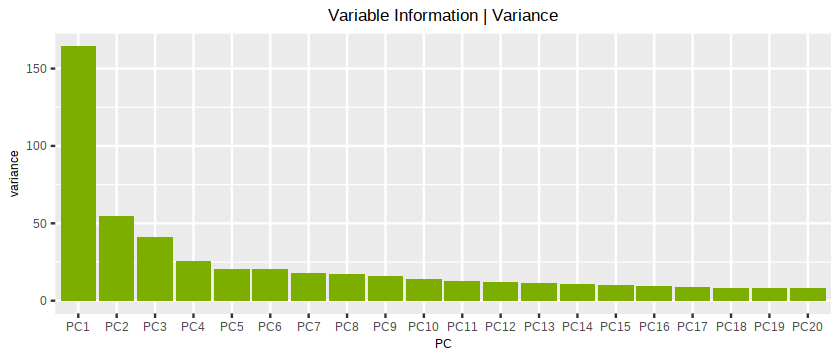

In [11]:
# Present a bar chart to visualize the variance of the first 20 principal components.
#
# You can use the var_info.var() function.
first.20 = data.pc[,c(1:20)]
first.20_variances = var_info.var(first.20)

ggplot() + ggtitle("Variable Information | Variance") + xlab("PC") + ylab("variance") + 
    geom_col(aes(reorder(names(first.20_variances), 1:20), first.20_variances), fill=PALETTE[3])

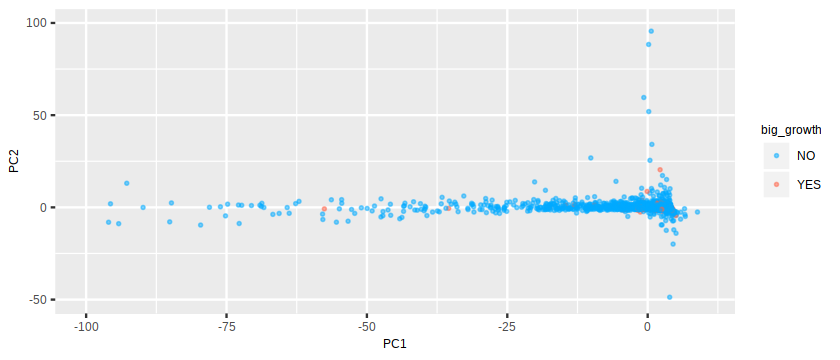

In [12]:
# Present a 2D scatterplot to visualize PC1 vs PC2 vs big_growth
# (for -100≤PC1≤10 on horizontal axis, -50≤PC2≤100 on vertical axis, and big_growth color-coded).
# Professor said to not worry about transparency since we are running on a different system
new.data.pc = data.pc[, 1:2]
new.data.pc$big_growth = data[, "big_growth"]

ggplot(new.data.pc) + xlim(-100,10) + ylim(-50,100) + 
geom_point(aes(x=PC1, y=PC2, color=big_growth), na.rm=TRUE, alpha=0.5, size=0.5) +
scale_color_manual(values=PALETTE[1:2], drop=FALSE) + theme.legend_title

### Transform the Data

In [13]:
# Change the representation of the data:
#   The first 3 columns are gvkey, tic, and conm
#   The next 2 columns are PC1 and PC2
#   The next 3 columns are prccq, growth, and big_growth
# Keep the variable names of the predictor variables for later use.
# Keep the variable names of the outcome variables for later use.
data = cbind(data[,c("gvkey", "tic", "conm")], data.pc[, 1:2], data[,c("prccq", "growth", "big_growth")])
transformed.predictor_vars = colnames(data[, !(colnames(data) %in% outvars)])
transformed.outcome_vars = colnames(data[, (colnames(data) %in% outvars)])

# How many observations and variables?
fmt(size(data), "")

# How many predictor variables?
# How many outcome variables?
length.outvars = factor((colnames(data) %in% outvars), levels=c(FALSE, TRUE))
length.outvars = sum(length.outvars == TRUE)
length.prevars = length(colnames(data)) - length.outvars

lengths.df = data.frame(length.prevars = length.prevars, length.outvars = length.outvars)
fmt(lengths.df, "")

# Present the few few observations of the resulting dataset.
head(data)

observations,variables
4305,8


length.prevars,length.outvars
5,3


gvkey,tic,conm,PC1,PC2,prccq,growth,big_growth
1004,AIR,AAR CORP,3.4371231,-0.2260719,43.69,0.0507455507,NO
1045,AAL,AMERICAN AIRLINES GROUP INC,-12.0332067,0.8045109,32.11,-0.3828560446,NO
1050,CECE,CECO ENVIRONMENTAL CORP,3.9532234,-0.7553386,6.75,0.3157894737,YES
1062,ASA,ASA GOLD AND PRECIOUS METALS,3.6561434,-0.7981915,8.66,-0.2164739518,NO
1072,AVX,AVX CORP,2.9282228,-0.7104200,15.25,-0.1184971098,NO
1075,PNW,PINNACLE WEST CAPITAL CORP,0.3488491,1.1389605,85.20,0.0002347969,NO


### Store Transformed Data

In [14]:
# Store the transformed data (4305 observations, 8 variables)
write.csv(data, "My Data.csv", row.names=FALSE)

In [15]:
# Store the variable names of the filtered data (923 predictor variable names)
saveRDS(cn, "My Pre-Filter.rds") # pre-filter column names kept for later use

In [16]:
# Store the PCA centroids and weight matrix
saveRDS(pc, "My PC.rds") # centroids and weight matrix kept for later use

In [17]:
# Store the imputation values (923 means and modes)
saveRDS(predictor.impute_values, "My Imputation.rds") # imputation values kept for later use

In [18]:
# Store the predictor variable names of the transformed data (5 predictor variable names)
saveRDS(transformed.predictor_vars, "My Post-Filter.rds") # post-filter predictor column names kept for later use

<font size=1;>
<p style="text-align: left;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float: right;">
Document revised March 26, 2020
</span>
</p>
</font>